In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
import shutil
import matplotlib.pyplot as plt
import sys
from collections import Counter
import re
sys.path.append('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts')
import IGTD_Functions as IGTD
from scipy.stats import spearmanr, rankdata
from scipy.spatial.distance import pdist, squareform
import time
import _pickle as cp
from astropy.stats import median_absolute_deviation

Mounted at /content/drive


## csv preprocessing (1-time operation)

In [ ]:
csv_path = '/content/drive/MyDrive/ABELE_prostate/PICAI_original/clinical_information/marksheet.csv'
patients_df = pd.read_csv(csv_path)

# Create a new CSV version, keeping only the most recent study to avoid duplicates
patient_labels_df = patients_df.copy()
patient_labels_df['mri_date'] = pd.to_datetime(patient_labels_df['mri_date'])
patient_labels_df = patient_labels_df.sort_values(by='mri_date', ascending=False)

# Drop duplicates, keeping only the first occurrence (most recent study) for each patient_id
patient_labels_df = patient_labels_df.drop_duplicates(subset='patient_id', keep='first')
patient_labels_df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
1349,11326,1001349,2021-08-15,70,5.0,0.12,41.0,SysBx+MRBx,"0+0,3+3","0,1",1,NO
984,10965,1000984,2021-08-15,83,13.0,0.24,53.0,SysBx+MRBx,4+5,5,5,YES
308,10302,1000308,2021-08-11,62,5.6,0.19,42.0,SysBx,0+0,0,0,NO
555,10544,1000555,2021-08-11,62,7.1,0.13,20.0,NaN,NaN,NaN,0,NO
1265,11242,1001265,2021-07-27,64,8.7,0.13,66.0,NaN,NaN,NaN,0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
1172,11149,1001172,2011-12-24,61,6.1,0.16,39.0,MRBx,"3+4,3+3","2,1",2,YES
923,10906,1000923,2011-12-20,72,18.7,0.22,83.0,NaN,NaN,NaN,0,NO
491,10483,1000491,2011-12-20,60,10.5,0.25,42.0,MRBx,3+3,1,1,NO
331,10325,1000331,2011-12-12,66,26.0,0.24,107.0,NaN,NaN,NaN,0,NO


In [ ]:
# Save the mapping DataFrame as a CSV file
patient_labels_df.to_csv('/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/clinical_info/marksheet.csv', index=False)

## conversion

In [ ]:
csv = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/clinical_info/marksheet.csv'

num_row = 64    # Number of pixel rows in image representation
num_col = 64    # Number of pixel columns in image representation
num = num_row * num_col # Number of features to be included for analysis, which is also the total number of pixels in image representation
save_image_size = 3 # Size of pictures (in inches) saved during the execution of IGTD algorithm.
max_step = 100000    # The maximum number of iterations to run the IGTD algorithm, if it does not converge.
val_step = 100  # The number of iterations for determining algorithm convergence. If the error reduction rate
                # is smaller than a pre-set threshold for val_step itertions, the algorithm converges.

# Import the example data and linearly scale each feature so that its minimum and maximum values are 0 and 1, respectively.
data = pd.read_csv(csv, header=0,index_col=0)
to_remove = ['study_id','lesion_GS','lesion_ISUP','case_ISUP','case_csPCa','mri_date','histopath_type']
data = data.drop(to_remove, axis=1)

numeric_cols = data.select_dtypes(include='number').columns
non_numeric_cols = data.select_dtypes(exclude=['number']).columns

data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
data = pd.get_dummies(data,columns=non_numeric_cols)

# Select features with large variations across samples
#id = IGTD.select_features_by_variation(data, variation_measure='var', num=num)
#data = data.iloc[:, id]

# Perform min-max transformation so that the maximum and minimum values of every feature become 1 and 0, respectively.
norm_data = IGTD.min_max_transform(data.values)
norm_data = pd.DataFrame(norm_data, columns=data.columns, index=data.index)
norm_data

,patient_age,psa,psad,prostate_volume
patient_id,,,,
11326,0.614035,0.021885,0.015737,0.121711
10965,0.842105,0.057615,0.032904,0.161184
10302,0.473684,0.024565,0.025751,0.125000
10544,0.473684,0.031264,0.017167,0.052632
11242,0.508772,0.038410,0.017167,0.203947
...,...,...,...,...
11149,0.456140,0.026798,0.021459,0.115132
10906,0.649123,0.083073,0.030043,0.259868
10483,0.438596,0.046449,0.034335,0.125000


In [ ]:
fea_dist_method = 'Pearson'
image_dist_method = 'Euclidean'
error = 'abs'
result_dir = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/tab_to_img/images3/'
os.makedirs(name=result_dir, exist_ok=True)

IGTD.table_to_image(norm_data, [num_row, num_col], fea_dist_method, image_dist_method, save_image_size,
                    max_step, val_step, result_dir, error)

Step 0 err: 9.0
Step 1 err: 5.0
Step 2 err: 5.0
Step 3 err: 5.0
Step 4 err: 5.0
Step 5 err: 5.0
Step 6 err: 5.0
Step 7 err: 5.0
Step 8 err: 5.0
Step 9 err: 5.0
Step 10 err: 5.0
Step 11 err: 5.0
Step 12 err: 5.0
Step 13 err: 5.0
Step 14 err: 5.0
Step 15 err: 5.0
Step 16 err: 5.0
Step 17 err: 5.0
Step 18 err: 5.0
Step 19 err: 5.0
Step 20 err: 5.0
Step 21 err: 5.0
Step 22 err: 5.0
Step 23 err: 5.0
Step 24 err: 5.0
Step 25 err: 5.0
Step 26 err: 5.0
Step 27 err: 5.0
Step 28 err: 5.0
Step 29 err: 5.0
Step 30 err: 5.0
Step 31 err: 5.0
Step 32 err: 5.0
Step 33 err: 5.0
Step 34 err: 5.0
Step 35 err: 5.0
Step 36 err: 5.0
Step 37 err: 5.0
Step 38 err: 5.0
Step 39 err: 5.0
Step 40 err: 5.0
Step 41 err: 5.0
Step 42 err: 5.0
Step 43 err: 5.0
Step 44 err: 5.0
Step 45 err: 5.0
Step 46 err: 5.0
Step 47 err: 5.0
Step 48 err: 5.0
Step 49 err: 5.0
Step 50 err: 5.0
Step 51 err: 5.0
Step 52 err: 5.0
Step 53 err: 5.0
Step 54 err: 5.0
Step 55 err: 5.0
Step 56 err: 5.0
Step 57 err: 5.0
Step 58 err: 5.0
Step 59

/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions.py:357: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(index_record).to_csv(save_folder + '/' + file_name + '_index.txt', header=False, index=False,
/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions.py:359: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(np.transpose(np.vstack((err_record, np.array(range(s + 2))))),
/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions.py:362: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  pd.DataFrame(np.transpose(np.vstack((err_record, run_time))), columns=['error', 'run_time']).to_csv(
/content/drive/MyDrive/ABELE_prostate/claudio/black_box/code/IGTD/Scripts/IGTD_Functions.py:616: FutureWarning: the 'line_terminator'' keyword is 

(388, 393)


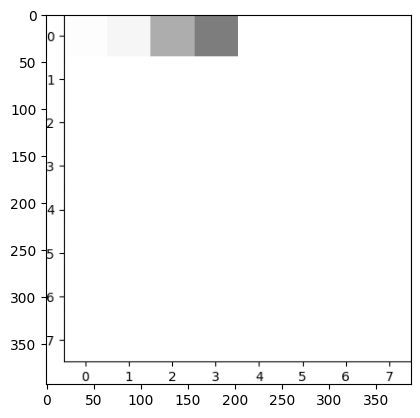

In [ ]:
from PIL import Image
img = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/tab_to_img/images3/data/_10001_image.png'
img = Image.open(img)
print(img.size)
plt.imshow(img)

In [ ]:
from PIL import Image
img = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/tab_to_img/images3/data/_10001_image.png'
img = Image.open(img)
from numpy import asarray
np_arr = asarray(img)
print(np_arr.shape)

(393, 388, 4)


## Extract image data and map into dictionary

In [ ]:
obj = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/tab_to_img/prova2/Results.pkl'
objects = []
with (open(obj, "rb")) as openfile:
    while True:
        try:
            objects.append(cp.load(openfile))
        except EOFError:
            break

In [ ]:
original_tab_data = objects[0]
generated_img_data = objects[1]
sample_names = objects[2]
mapping_dict = {}

for i in range(len(sample_names)):
    patient_id = sample_names[i]
    image_data = generated_img_data[:,:,i]

    mapping_dict[patient_id] = image_data

##text to array
take the first 4 values from each textfile, turn them into a 2x2 matrix and then repeat them until a 64x64 matrix is created

In [ ]:
path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/tab_to_img/images3/data/'

def text_to_64x64(text_filepath: str):
    with open(text_file,'r') as f:
        content = f.read()
        values = np.asarray(content.split())[:4].astype(np.float32)
        mat2x2 = np.reshape(values,(-1,2))
        mat64x64 = np.tile(mat2x2,(32,32))
    return mat64x64.astype(np.float32)


#np.set_printoptions(threshold=np.inf)
mapping_dict = {}
for i,(file) in sorted(enumerate(os.listdir(path)),key=lambda x:x[1]):
    if file.endswith('.txt'):
        patient_id = file.split("_")[1]
        text_file = os.path.join(path,file)
        image_tabular = text_to_64x64(text_file)
        print(patient_id,'\n',image_tabular,'\nshape: ',image_tabular.shape,'\n')
        mapping_dict[patient_id]=image_tabular

Streaming output truncated to the last 5000 lines.
 [ 18.791872  10.579399  18.791872 ...  10.579399  18.791872  10.579399]
 [111.8421    42.779606 111.8421   ...  42.779606 111.8421    42.779606]
 ...
 [ 18.791872  10.579399  18.791872 ...  10.579399  18.791872  10.579399]
 [111.8421    42.779606 111.8421   ...  42.779606 111.8421    42.779606]
 [ 18.791872  10.579399  18.791872 ...  10.579399  18.791872  10.579399]] 
shape:  (64, 64) 

11107 
 [[129.73685    85.55921   129.73685   ...  85.55921   129.73685
   85.55921  ]
 [  4.327825    0.7296137   4.327825  ...   0.7296137   4.327825
    0.7296137]
 [129.73685    85.55921   129.73685   ...  85.55921   129.73685
   85.55921  ]
 ...
 [  4.327825    0.7296137   4.327825  ...   0.7296137   4.327825
    0.7296137]
 [129.73685    85.55921   129.73685   ...  85.55921   129.73685
   85.55921  ]
 [  4.327825    0.7296137   4.327825  ...   0.7296137   4.327825
    0.7296137]] 
shape:  (64, 64) 

11108 
 [[161.05263    17.615131  161.05263   .

In [ ]:
import pickle
file_path = '/content/drive/MyDrive/ABELE_prostate/claudio/black_box/data/tab_to_img/mapping_dict.pkl'

# save dictionary to person_data.pkl file
with open(file_path,'wb') as fp:
    pickle.dump(mapping_dict,fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file
